In [1]:
import pandas as pd
import dask.dataframe as dd
import random
import math
from pathlib import Path
import dask
from distributed import Client

In [2]:
c = Client()

# Generate Trade Files

In [3]:
max_trade_files_per_ns = 200_000
n_paths = 50_000
n_dates = 120
max_paths_per_partition = 50_000 # 10 # 200

memory_needed_per_row_gb = 138/1024/6_000_000
n_partitions = math.ceil(n_paths/max_paths_per_partition)
min_node_memory_needed_gb = (memory_needed_per_row_gb * n_paths * n_dates / n_partitions) * max_trade_files_per_ns

In [4]:
min_node_memory_needed_gb

26953.125

In [5]:
all_rows = []
n_files_to_create = 1
trade_folder = './row_partitioned_trade_files'

In [6]:
dates = pd.date_range("2021-07-01", freq="3M", periods=n_dates)
for file_no in range(n_files_to_create):
    print(f'Creating File {file_no:03d}')
    for path in range(n_paths):
        for date in dates:
            all_rows.append([date, path, random.random()*200-100]) 
    
    df = pd.DataFrame(all_rows, columns=['date', 'path', 'mtm']).astype({'path': 'int32', 'mtm': 'float64'}).set_index('path')
    df.date = pd.to_datetime(df.date)
    ddf = dd.from_pandas(df, npartitions=n_partitions)
    trade_filepath = f'{trade_folder}/row_partitioned_trade_file_{file_no:03d}.parquet'
    ddf.to_parquet(trade_filepath)

Creating File 000


In [7]:
files = sorted(list(Path(trade_folder).glob('*.parquet')))
files

[PosixPath('row_partitioned_trade_files/row_partitioned_trade_file_000.parquet'),
 PosixPath('row_partitioned_trade_files/row_partitioned_trade_file_001.parquet'),
 PosixPath('row_partitioned_trade_files/row_partitioned_trade_file_002.parquet')]

In [10]:
ddfs = [dd.read_parquet(file) for file in files[0:1]]

In [9]:
massive_ddf = dd.concat(ddfs)

In [10]:
# ddfs[0].to_delayed()

# Easy, dumb approach

In [11]:
%%time
ns_summed_df = massive_ddf.groupby(['date', 'path']).sum()
epe = ns_summed_df.mtm.mask(ns_summed_df.mtm < 0, 0)
epe.name = "EPE"
ene = ns_summed_df.mtm.mask(ns_summed_df.mtm > 0, 0)
ene.name = "ENE"
agg_df = dd.concat([ene, epe], axis=1).groupby('date').agg({"EPE": ["mean"], "ENE": ["mean"]})
agg_df.columns = ["ENE", "EPE"]
final_df = agg_df.compute()
display(final_df.shape)
final_df

/home/balast/.conda/envs/rbc/lib/python3.9/site-packages/dask/dataframe/multi.py:1196: UserWarning: Concatenating dataframes with unknown divisions.
We're assuming that the indices of each dataframes are 
 aligned. This assumption is not generally safe.
  warnings.warn(


(120, 2)

CPU times: user 125 ms, sys: 5.57 ms, total: 130 ms
Wall time: 317 ms


,ENE,EPE
date,,
2021-07-31,93.700906,-93.265708
2021-10-31,79.560979,-79.123928
2022-01-31,102.457577,-93.377472
2022-04-30,96.082290,-83.006435
2022-07-31,97.739922,-111.406207
...,...,...
2050-04-30,99.747841,-80.469207
2050-07-31,71.061696,-87.841068
2050-10-31,69.369588,-89.855798


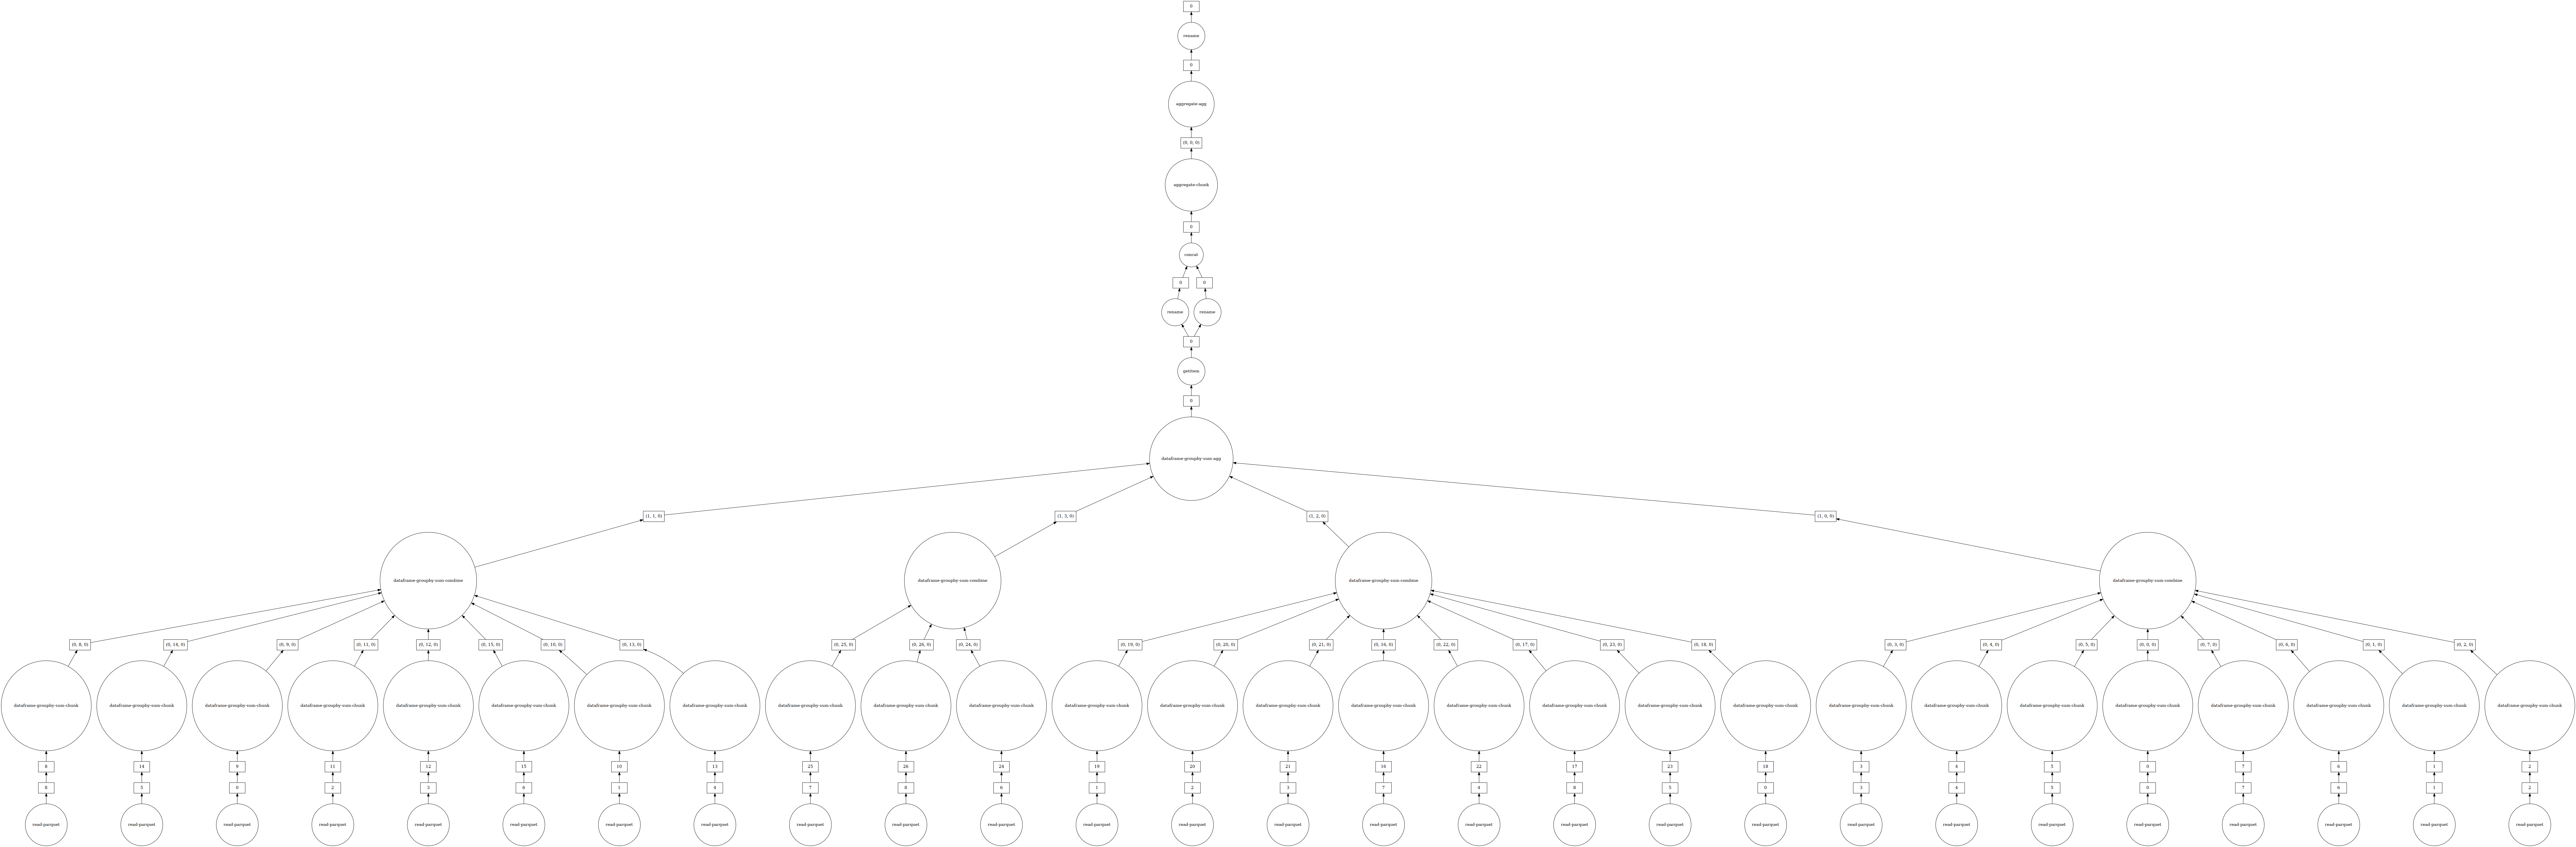

In [19]:
dask.optimize(agg_df)[0].visualize()

In [12]:
agg_df.visualize()

In [23]:
agg_df.__dask_graph__()

layer_type,MaterializedLayer
is_materialized,True
npartitions,27
columns,"['date', 'mtm']"
type,dask.dataframe.core.DataFrame
dataframe_type,pandas.core.frame.DataFrame
series_dtypes,"{'date': dtype('<M8[ns]'), 'mtm': dtype('float64')}"
layer_type,MaterializedLayer
is_materialized,True
npartitions,1
columns,['mtm']


In [52]:
%%time
agg_df.compute()

CPU times: user 86.4 ms, sys: 10.8 ms, total: 97.2 ms
Wall time: 228 ms


,ENE,EPE
date,,
2021-07-31,72.294804,-88.327205
2021-10-31,92.283580,-81.891615
2022-01-31,107.164492,-83.130658
2022-04-30,108.138047,-80.976369
2022-07-31,108.394720,-71.183015
...,...,...
2050-04-30,91.291081,-102.744378
2050-07-31,96.219975,-87.039136
2050-10-31,80.952178,-90.893429


In [53]:
%%time
dask.persist(agg_df)[0]

CPU times: user 9.07 ms, sys: 0 ns, total: 9.07 ms
Wall time: 8.14 ms


,ENE,EPE
npartitions=1,,
,float64,float64
,...,...


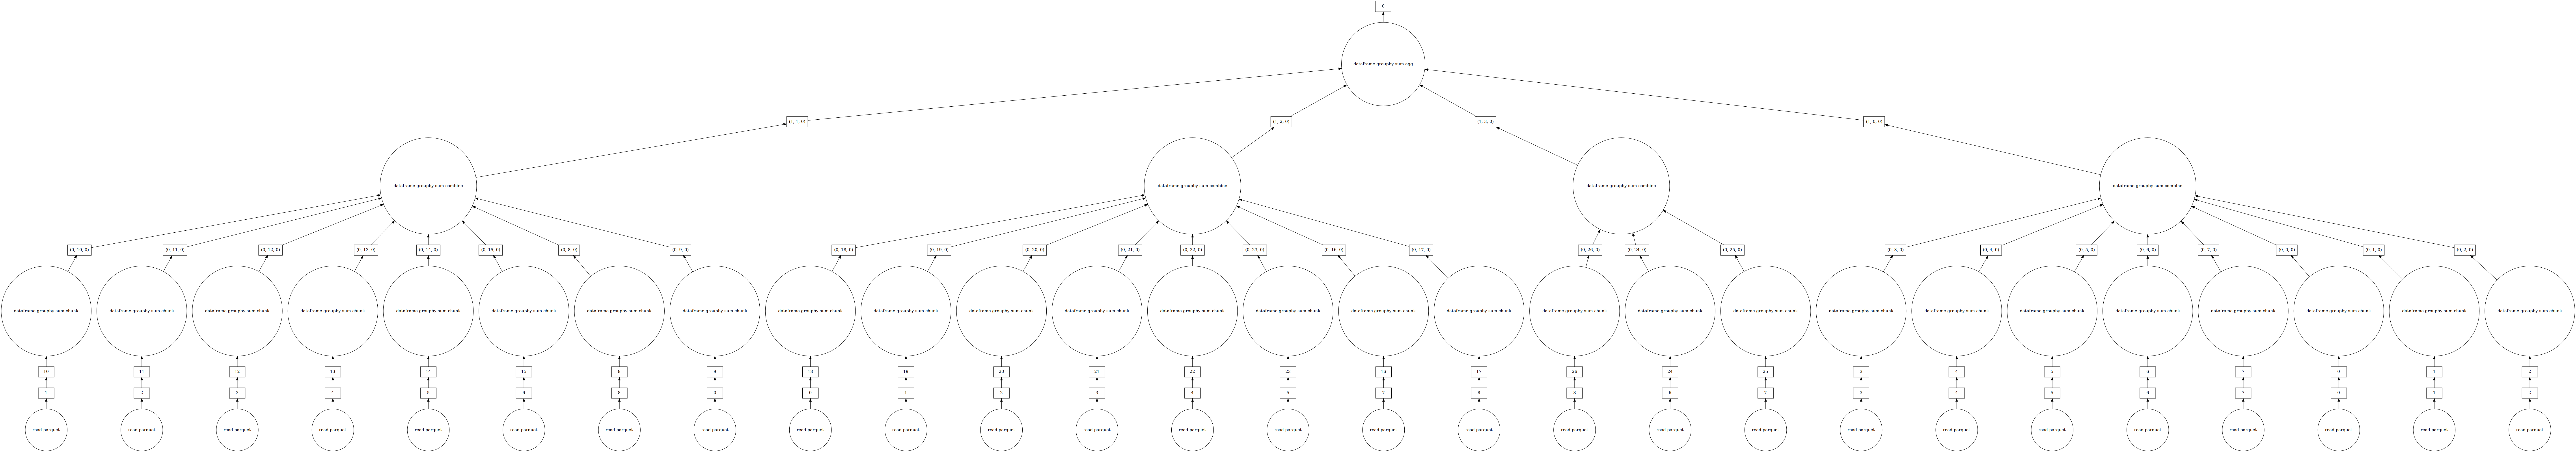

In [54]:
ns_summed_df.visualize()

# Manual Approach

In [104]:
%%time
n_partitions = ddfs[0].npartitions
path_ddfs = []
for partition_index in range(n_partitions):
    path_ddfs.append(dd.concat([ddfs[ddf_index].partitions[partition_index] for ddf_index in range(len(ddfs))]))

CPU times: user 5.27 s, sys: 158 ms, total: 5.43 s
Wall time: 5 s


In [105]:
%%time
path_agged_ddfs = []
for path_ddf in path_ddfs:
    path_agged_ddfs.append(path_ddf.groupby(['date', 'path']).sum())

CPU times: user 1.74 s, sys: 57.1 ms, total: 1.79 s
Wall time: 1.62 s


In [122]:
%%time
ns_agged_df = dd.concat(path_agged_ddfs)
ns_agged_df.compute()

CPU times: user 4.97 s, sys: 195 ms, total: 5.17 s
Wall time: 6.97 s


mtm
date       path            
2021-07-31 0     170.250093
           1    -329.309941
           2     102.033482
           3    -303.314452
           4     141.237153
...                     ...
2051-04-30 3595  -27.055090
           3596  -74.162264
           3597 -344.542155
           3598   84.587525
           3599  411.616091

[432000 rows x 1 columns]

In [123]:
persisted_ns_agged_df = dask.persist(ns_agged_df)[0]

In [142]:
%%time
dask.compute(ns_agged_df)[0]

CPU times: user 536 ms, sys: 5.67 ms, total: 542 ms
Wall time: 546 ms


mtm
date       path            
2021-07-31 0     170.250093
           1    -329.309941
           2     102.033482
           3    -303.314452
           4     141.237153
...                     ...
2051-04-30 3595  -27.055090
           3596  -74.162264
           3597 -344.542155
           3598   84.587525
           3599  411.616091

[432000 rows x 1 columns]

In [143]:
%%time
dask.compute(persisted_ns_agged_df)[0]

CPU times: user 228 ms, sys: 11.3 ms, total: 239 ms
Wall time: 244 ms


mtm
date       path            
2021-07-31 0     170.250093
           1    -329.309941
           2     102.033482
           3    -303.314452
           4     141.237153
...                     ...
2051-04-30 3595  -27.055090
           3596  -74.162264
           3597 -344.542155
           3598   84.587525
           3599  411.616091

[432000 rows x 1 columns]